In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Funciones benchmark 
def sphere(x):
    return np.sum(x**2)

def rosenbrock(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def rastrigin(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def ackley(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    sum_sq = np.sum(x**2)
    sum_cos = np.sum(np.cos(c * x))
    n = len(x)
    return -a * np.exp(-b * np.sqrt(sum_sq/n)) - np.exp(sum_cos/n) + a + np.exp(1)

def griewank(x):
    sum_part = np.sum(x**2) / 4000
    prod_part = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x)+1))))
    return sum_part - prod_part + 1

def schwefel(x):
    return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))

def zakharov(x):
    sum1 = np.sum(x**2)
    sum2 = np.sum(0.5 * np.arange(1, len(x)+1) * x)
    return sum1 + sum2**2 + sum2**4

def michalewicz(x, m=10):
    i = np.arange(1, len(x)+1)
    return -np.sum(np.sin(x) * np.sin((i * x**2)/np.pi)**(2*m))

In [3]:
class PSO:
    def __init__(self, func, dim, bounds, num_particles=30, max_iter=100, w=0.7, c1=1.5, c2=1.5):
        self.func = func
        self.dim = dim
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w  # inertia weight
        self.c1 = c1  # cognitive coefficient
        self.c2 = c2  # social coefficient
        
        # Initialize particles
        self.particles = np.random.uniform(bounds[0], bounds[1], (num_particles, dim))
        self.velocities = np.zeros((num_particles, dim))
        
        # Initialize best positions
        self.pbest_pos = self.particles.copy()
        self.pbest_val = np.array([func(p) for p in self.particles])
        
        # Initialize global best
        self.gbest_idx = np.argmin(self.pbest_val)
        self.gbest_pos = self.pbest_pos[self.gbest_idx].copy()
        self.gbest_val = self.pbest_val[self.gbest_idx]
        
        # Store best values for plotting
        self.best_values = []
    
    def optimize(self):
        for _ in range(self.max_iter):
            # Update velocities and positions
            r1, r2 = np.random.rand(2)
            self.velocities = (self.w * self.velocities + 
                              self.c1 * r1 * (self.pbest_pos - self.particles) + 
                              self.c2 * r2 * (self.gbest_pos - self.particles))
            
            self.particles += self.velocities
            
            # Apply bounds
            self.particles = np.clip(self.particles, self.bounds[0], self.bounds[1])
            
            # Evaluate current positions
            current_val = np.array([self.func(p) for p in self.particles])
            
            # Update personal best
            improved_idx = current_val < self.pbest_val
            self.pbest_pos[improved_idx] = self.particles[improved_idx]
            self.pbest_val[improved_idx] = current_val[improved_idx]
            
            # Update global best
            current_best_idx = np.argmin(self.pbest_val)
            if self.pbest_val[current_best_idx] < self.gbest_val:
                self.gbest_pos = self.pbest_pos[current_best_idx].copy()
                self.gbest_val = self.pbest_val[current_best_idx]
            
            self.best_values.append(self.gbest_val)
        
        return self.gbest_pos, self.gbest_val
    
    def plot_convergence(self):
        plt.plot(self.best_values)
        plt.title('Convergence Curve (PSO)')
        plt.xlabel('Iteration')
        plt.ylabel('Best Value')
        plt.grid()
        plt.show()

In [4]:
class CCO:
    def __init__(self, func, dim, bounds, num_nests=25, max_iter=100, pa=0.25, step_size=1.0):
        self.func = func
        self.dim = dim
        self.bounds = bounds
        self.num_nests = num_nests
        self.max_iter = max_iter
        self.pa = pa  # probability of discovery
        self.step_size = step_size
        
        # Initialize nests
        self.nests = np.random.uniform(bounds[0], bounds[1], (num_nests, dim))
        self.fitness = np.array([func(n) for n in self.nests])
        
        # Find best nest
        self.best_idx = np.argmin(self.fitness)
        self.best_nest = self.nests[self.best_idx].copy()
        self.best_fitness = self.fitness[self.best_idx]
        
        # Store best values for plotting
        self.best_values = []
    
    def optimize(self):
        for _ in range(self.max_iter):
            # Generate new solutions via Lévy flights
            new_nests = self.nests.copy()
            for i in range(self.num_nests):
                step = self.step_size * self.levy_flight()
                new_nests[i] += step
                # Apply bounds
                new_nests[i] = np.clip(new_nests[i], self.bounds[0], self.bounds[1])
            
            # Evaluate new solutions
            new_fitness = np.array([self.func(n) for n in new_nests])
            
            # Replace worse nests with new better solutions
            improved_idx = new_fitness < self.fitness
            self.nests[improved_idx] = new_nests[improved_idx]
            self.fitness[improved_idx] = new_fitness[improved_idx]
            
            # Abandon some worse nests and build new ones
            abandon_mask = np.random.rand(self.num_nests) < self.pa
            num_abandon = np.sum(abandon_mask)
            if num_abandon > 0:
                self.nests[abandon_mask] = np.random.uniform(
                    self.bounds[0], self.bounds[1], (num_abandon, self.dim))
                self.fitness[abandon_mask] = np.array(
                    [self.func(n) for n in self.nests[abandon_mask]])
            
            # Find the best nest
            current_best_idx = np.argmin(self.fitness)
            if self.fitness[current_best_idx] < self.best_fitness:
                self.best_nest = self.nests[current_best_idx].copy()
                self.best_fitness = self.fitness[current_best_idx]
            
            self.best_values.append(self.best_fitness)
        
        return self.best_nest, self.best_fitness
    
    def levy_flight(self):
        beta = 1.5
        sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2)) / \
                (math.gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2))**(1 / beta)
        u = np.random.randn(self.dim) * sigma
        v = np.random.randn(self.dim)
        step = u / (np.abs(v)**(1 / beta))
        return step
    
    def plot_convergence(self):
        plt.plot(self.best_values)
        plt.title('Convergence Curve (CCO)')
        plt.xlabel('Iteration')
        plt.ylabel('Best Value')
        plt.grid()
        plt.show()


Testing Sphere (2D)

Running PSO...
PSO - Best Position: [-2.14606433e-07  1.43868462e-07]
PSO - Best Value: 0.000000


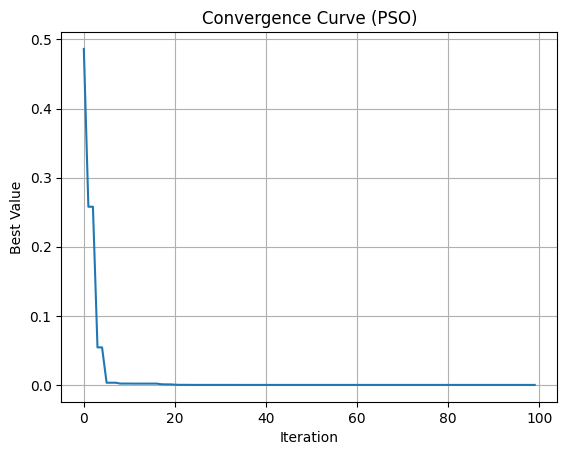


Running CCO...
CCO - Best Position: [ 0.00385294 -0.02178745]
CCO - Best Value: 0.000490


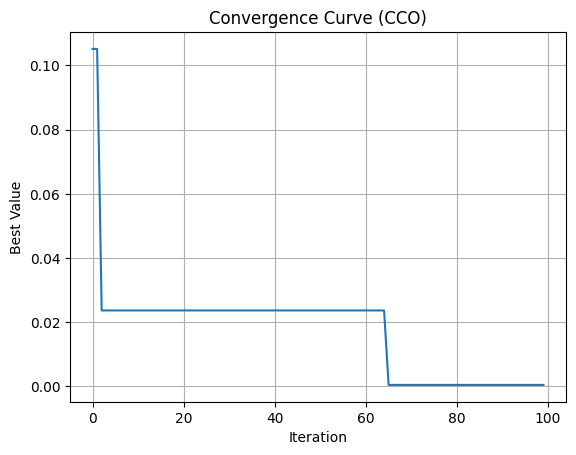


Testing Sphere (10D)

Running PSO...
PSO - Best Position: [ 0.03074576 -0.0062543  -0.0143433  -0.09427644  0.01556421  0.06688189
  0.08025787  0.05599297 -0.08585975 -0.12448084]
PSO - Best Value: 0.047238


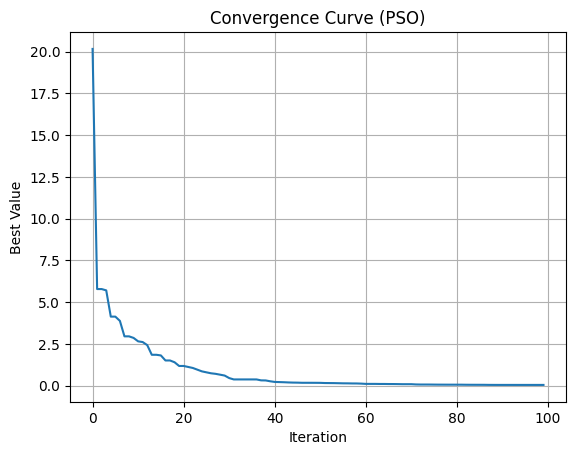


Running CCO...
CCO - Best Position: [-0.75851201 -1.36887856  0.63121716  0.40539551 -0.08991724 -1.66417447
  0.60084144 -2.28931483 -0.76470541 -1.3465317 ]
CCO - Best Value: 13.789406


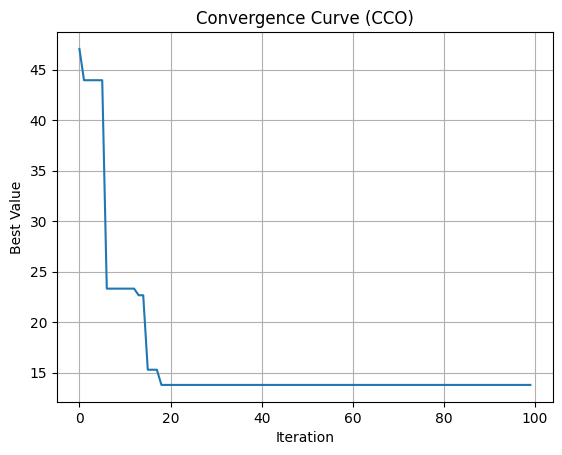


Testing Rosenbrock (2D)

Running PSO...
PSO - Best Position: [1.00000352 1.0000072 ]
PSO - Best Value: 0.000000


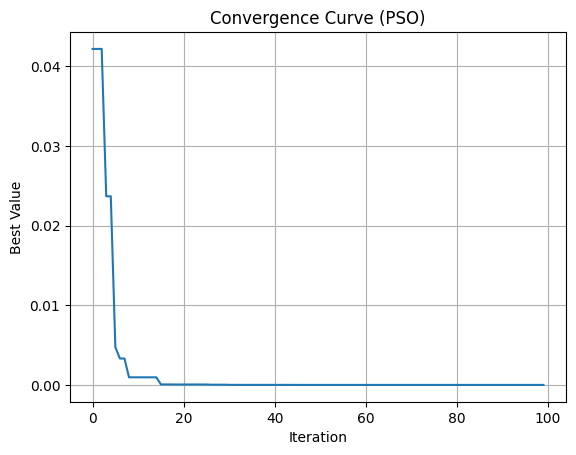


Running CCO...
CCO - Best Position: [0.99298118 0.98329382]
CCO - Best Value: 0.000788


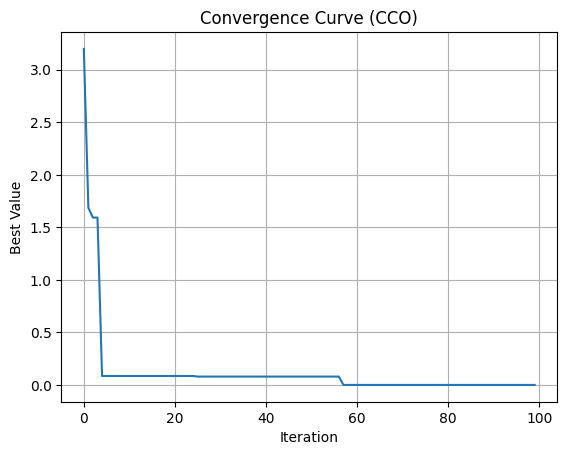


Testing Rosenbrock (10D)

Running PSO...
PSO - Best Position: [ 0.82159224  0.76442192  0.59390299  0.33205249  0.07736449 -0.53261979
  0.78119972  0.90172157  1.03694436  1.22085289]
PSO - Best Value: 74.303355


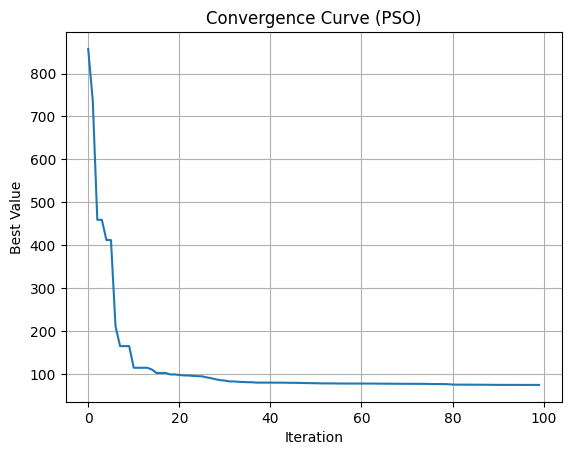


Running CCO...
CCO - Best Position: [ 0.25652149  0.93640055  0.28336182 -0.16989708  1.02775508  0.52372771
  0.12983849 -0.48834545  0.48080445 -0.11142221]
CCO - Best Value: 296.542700


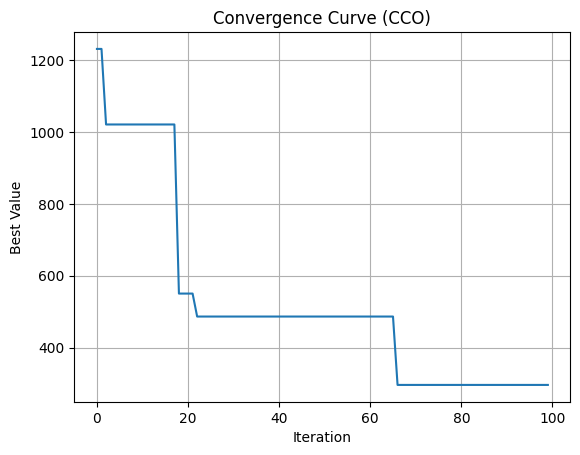


Testing Rastrigin (2D)

Running PSO...
PSO - Best Position: [ 5.00823227e-07 -4.34117939e-07]
PSO - Best Value: 0.000000


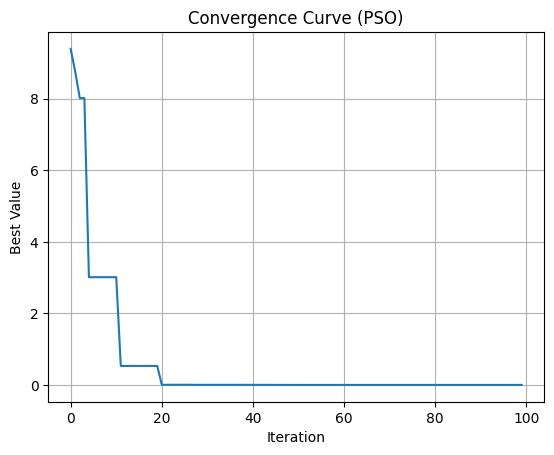


Running CCO...
CCO - Best Position: [0.0011104  0.02710987]
CCO - Best Value: 0.145701


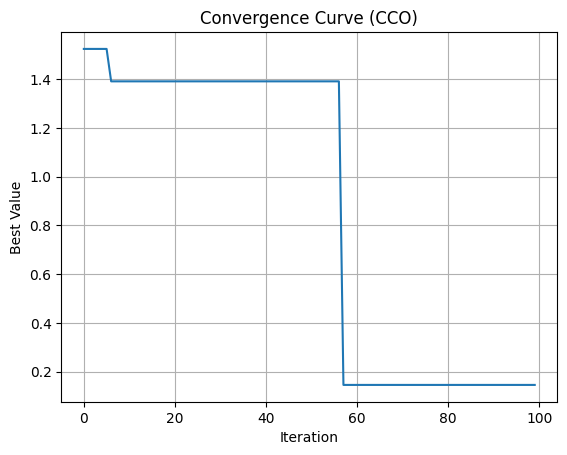


Testing Rastrigin (10D)

Running PSO...
PSO - Best Position: [ 1.07579968 -0.11020092 -1.00778404  0.03013711  0.97866222 -0.00822387
  1.9466061   1.97372432  1.02394707 -1.00566782]
PSO - Best Value: 17.410924


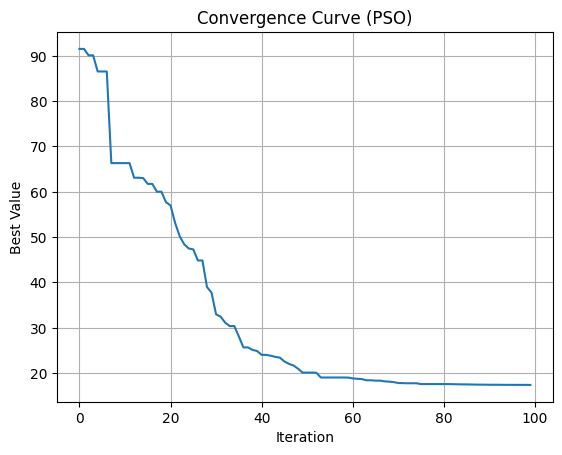


Running CCO...
CCO - Best Position: [-1.97099772e+00 -1.90199404e+00  1.05086067e+00 -1.06518550e+00
  1.38062171e-03 -3.93326439e+00  3.42880560e+00 -8.52572283e-01
 -2.06465750e+00 -1.26540847e+00]
CCO - Best Value: 82.550813


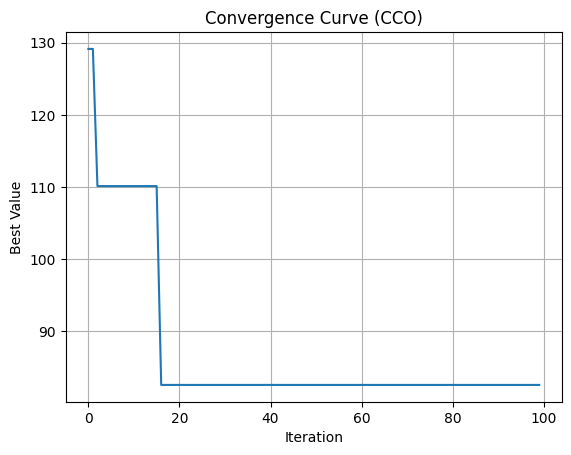


Testing Ackley (2D)

Running PSO...
PSO - Best Position: [6.12266030e-07 8.97685171e-08]
PSO - Best Value: 0.000002


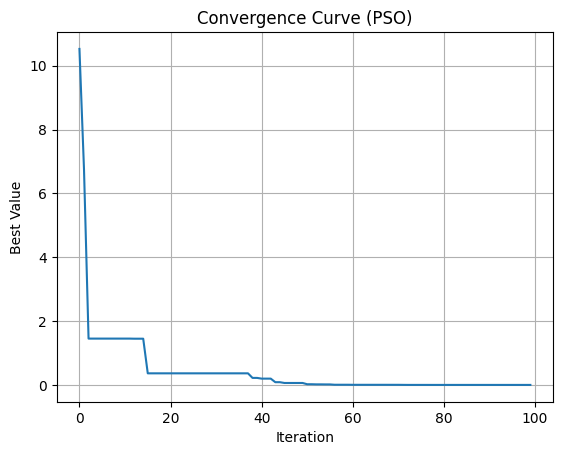


Running CCO...
CCO - Best Position: [-0.06318753 -0.06837301]
CCO - Best Value: 0.481420


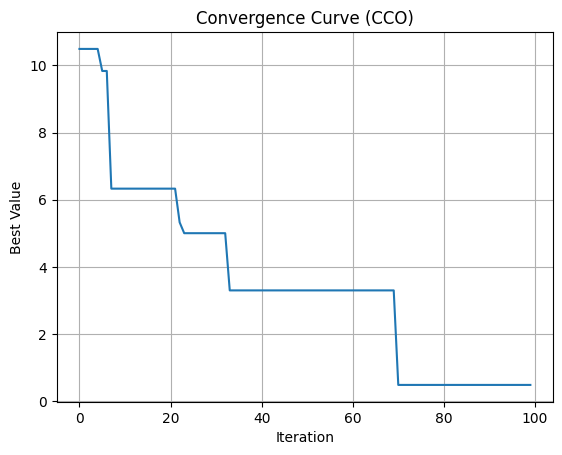


Testing Ackley (10D)

Running PSO...
PSO - Best Position: [-5.95498686  0.96418766 -5.95363869  2.0006325   0.05596002  7.99880877
  9.90902681 -1.9890734   3.05510202 -3.00806175]
PSO - Best Value: 12.895683


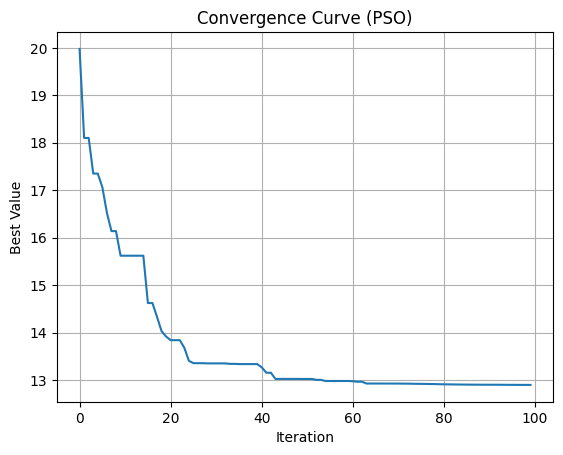


Running CCO...
CCO - Best Position: [  8.75982452   0.09382582   8.89655164   6.79883268  -1.08601878
 -13.89688938  -1.24504776  -4.32344437  -0.70767894   0.54782222]
CCO - Best Value: 16.002029


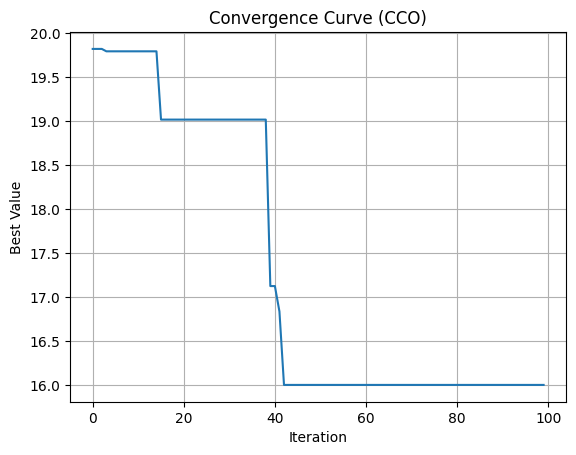


Testing Griewank (2D)

Running PSO...
PSO - Best Position: [-6.28030637e+00  2.84577999e-04]
PSO - Best Value: 0.009865


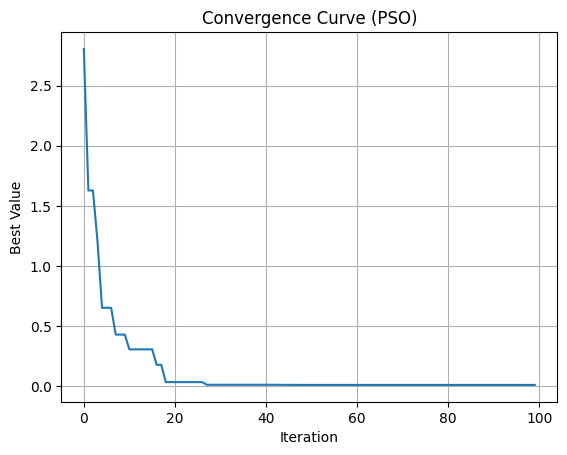


Running CCO...
CCO - Best Position: [ 9.21927308 39.58969794]
CCO - Best Value: 0.472303


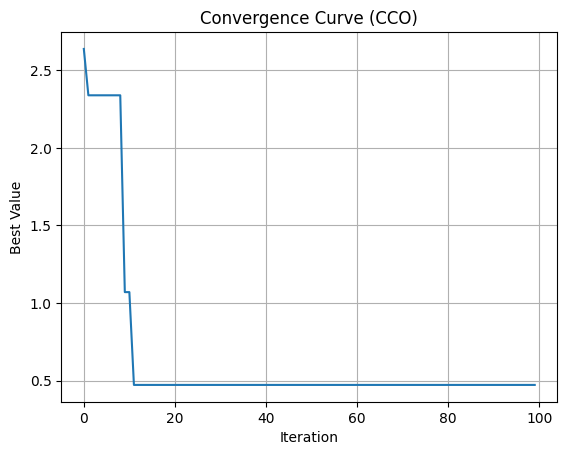


Testing Griewank (10D)

Running PSO...
PSO - Best Position: [ -6.2374247   26.46368979  10.94784953 -31.04635865  -7.57233555
  23.57552398   7.73325197  18.71844684 -18.23371388  -0.73831666]
PSO - Best Value: 0.983166


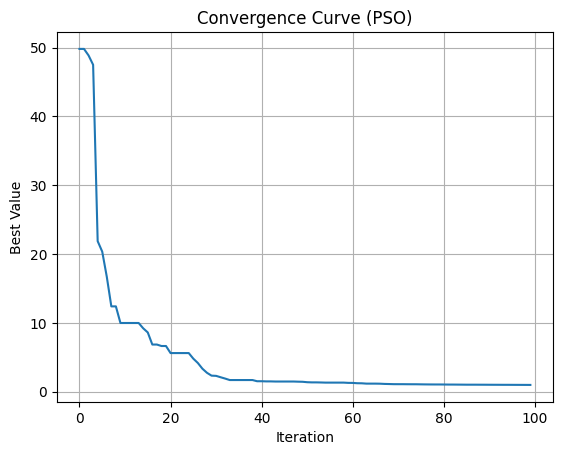


Running CCO...
CCO - Best Position: [ 151.14551753  201.62138449  -90.43973932 -139.1010543  -154.24837146
  -44.9576528  -113.33526059  -99.75074649 -112.2820161   -50.63861545]
CCO - Best Value: 39.672320


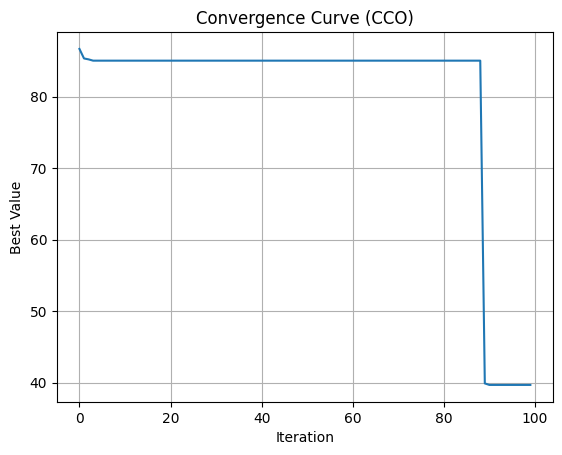


Testing Schwefel (2D)

Running PSO...
PSO - Best Position: [-302.52496042  420.96872449]
PSO - Best Value: 118.438360


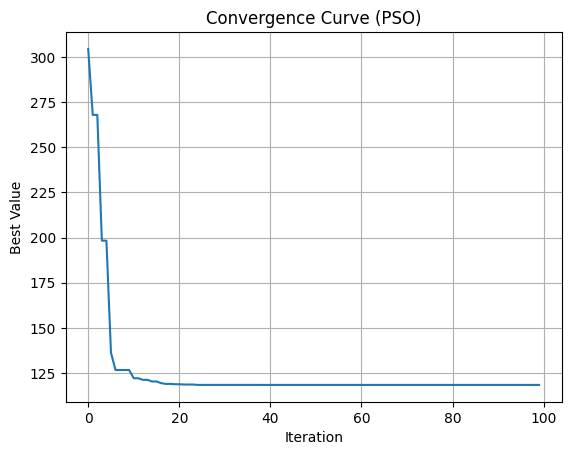


Running CCO...
CCO - Best Position: [406.26807596 430.28366833]
CCO - Best Value: 37.758380


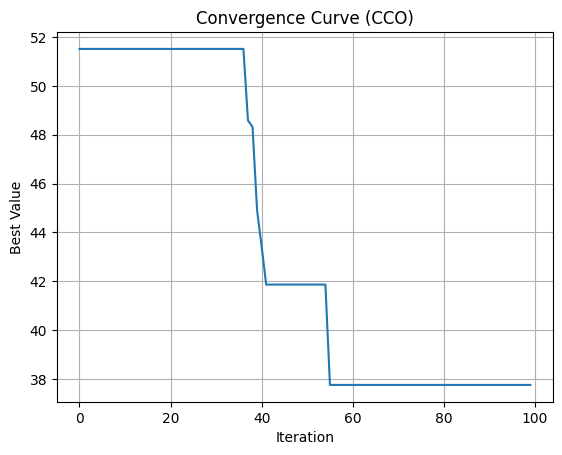


Testing Schwefel (10D)

Running PSO...
PSO - Best Position: [ 425.01968542 -297.07903066  205.12773866 -307.93315113  423.53472757
 -313.11802605 -304.45292841  204.39490726  203.18135276  196.52018018]
PSO - Best Value: 1374.328829


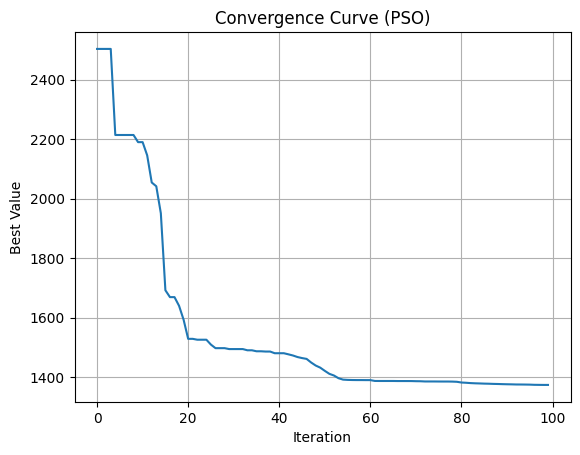


Running CCO...
CCO - Best Position: [ 444.73913499  439.6380524  -497.81283067  252.54316518  452.87577672
  211.00568712 -325.61696595  410.62097557 -110.24970013  250.89079917]
CCO - Best Value: 2159.762850


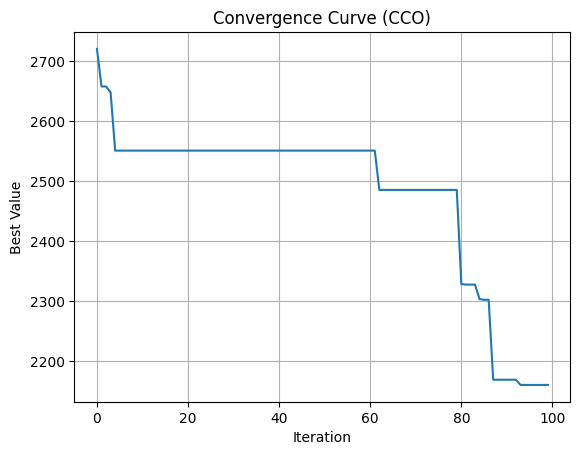


Testing Zakharov (2D)

Running PSO...
PSO - Best Position: [ 5.42379334e-07 -1.76105815e-06]
PSO - Best Value: 0.000000


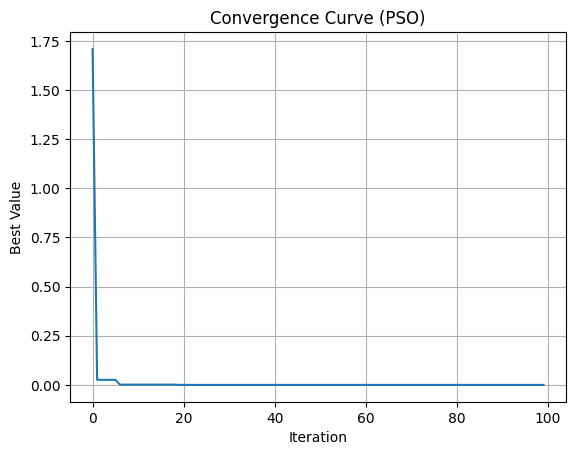


Running CCO...
CCO - Best Position: [ 0.14067905 -0.05815583]
CCO - Best Value: 0.023321


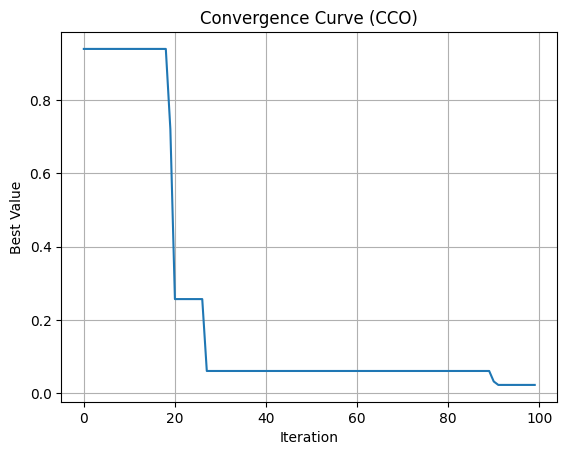


Testing Zakharov (10D)

Running PSO...
PSO - Best Position: [-0.03678502  0.0120945   0.15775958  0.10174698 -0.1282855  -0.17520295
 -0.02186851  0.40366781 -0.40440877  0.1138597 ]
PSO - Best Value: 0.439672


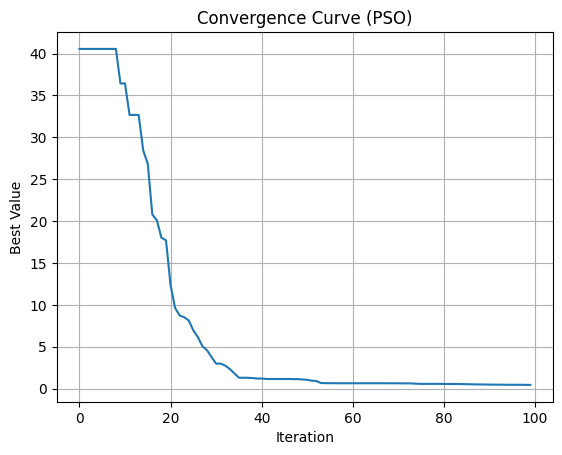


Running CCO...
CCO - Best Position: [-2.37941701  0.82049767  1.07971388 -2.85030932  4.5195297  -2.76389539
 -2.43903501 -3.8053314   1.32195639  3.71278024]
CCO - Best Value: 80.350272


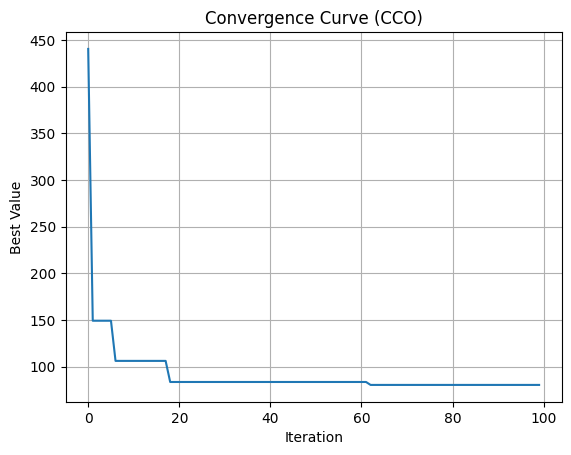


Testing Michalewicz (2D)

Running PSO...
PSO - Best Position: [2.20290552 1.57079633]
PSO - Best Value: -1.801303


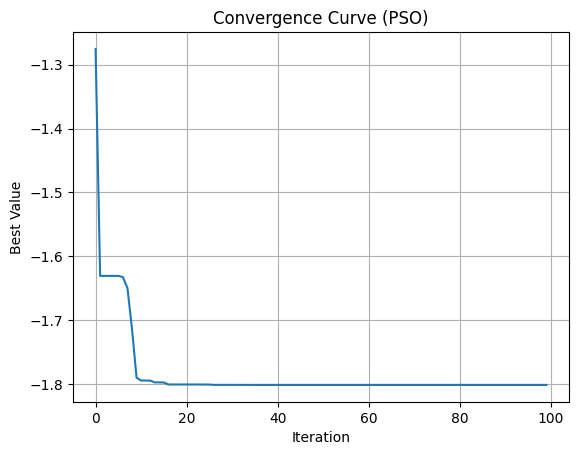


Running CCO...
CCO - Best Position: [2.1489272 1.5701233]
CCO - Best Value: -1.756305


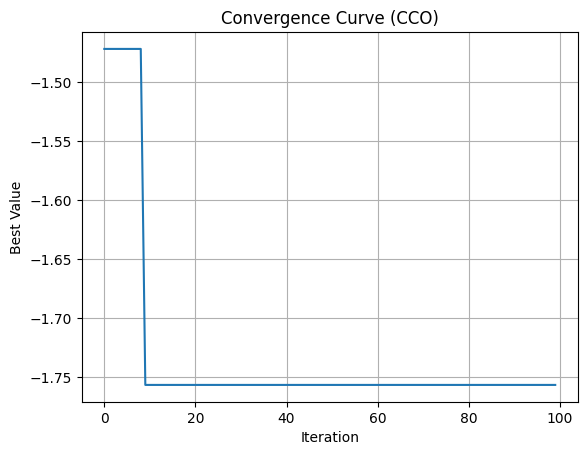


Testing Michalewicz (10D)

Running PSO...
PSO - Best Position: [2.23137712 1.56857308 1.63827691 0.56635602 1.38391563 0.90350161
 2.22158966 1.36023702 1.65676124 1.42370157]
PSO - Best Value: -5.341204


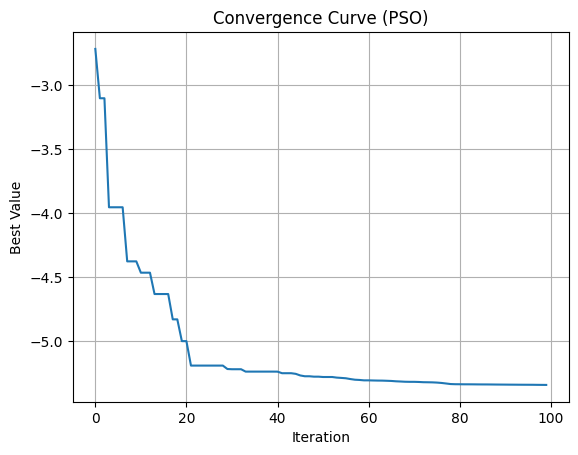


Running CCO...
CCO - Best Position: [2.14250436 2.25397696 0.79326901 1.10972083 0.         0.94351536
 0.74175448 1.36008343 0.         1.56674981]
CCO - Best Value: -4.487882


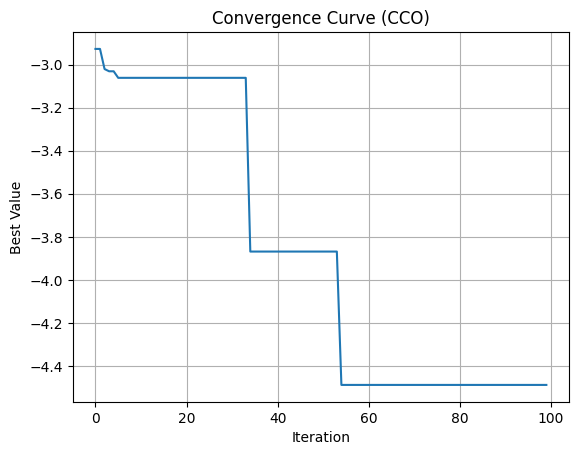

In [5]:
def test_algorithms():
    # Configuración de pruebas
    test_cases = [
        {'name': 'Sphere (2D)', 'func': sphere, 'dim': 2, 'bounds': (-5, 5)},
        {'name': 'Sphere (10D)', 'func': sphere, 'dim': 10, 'bounds': (-5, 5)},
        {'name': 'Rosenbrock (2D)', 'func': rosenbrock, 'dim': 2, 'bounds': (-2, 2)},
        {'name': 'Rosenbrock (10D)', 'func': rosenbrock, 'dim': 10, 'bounds': (-2, 2)},
        {'name': 'Rastrigin (2D)', 'func': rastrigin, 'dim': 2, 'bounds': (-5.12, 5.12)},
        {'name': 'Rastrigin (10D)', 'func': rastrigin, 'dim': 10, 'bounds': (-5.12, 5.12)},
        {'name': 'Ackley (2D)', 'func': ackley, 'dim': 2, 'bounds': (-32, 32)},
        {'name': 'Ackley (10D)', 'func': ackley, 'dim': 10, 'bounds': (-32, 32)},
        {'name': 'Griewank (2D)', 'func': griewank, 'dim': 2, 'bounds': (-600, 600)},
        {'name': 'Griewank (10D)', 'func': griewank, 'dim': 10, 'bounds': (-600, 600)},
        {'name': 'Schwefel (2D)', 'func': schwefel, 'dim': 2, 'bounds': (-500, 500)},
        {'name': 'Schwefel (10D)', 'func': schwefel, 'dim': 10, 'bounds': (-500, 500)},
        {'name': 'Zakharov (2D)', 'func': zakharov, 'dim': 2, 'bounds': (-5, 10)},
        {'name': 'Zakharov (10D)', 'func': zakharov, 'dim': 10, 'bounds': (-5, 10)},
        {'name': 'Michalewicz (2D)', 'func': michalewicz, 'dim': 2, 'bounds': (0, np.pi)},
        {'name': 'Michalewicz (10D)', 'func': michalewicz, 'dim': 10, 'bounds': (0, np.pi)}
    ]
    
    for case in test_cases:
        print(f"\nTesting {case['name']}")
        
        # PSO
        print("\nRunning PSO...")
        pso = PSO(case['func'], case['dim'], case['bounds'])
        best_pos, best_val = pso.optimize()
        print(f"PSO - Best Position: {best_pos}")
        print(f"PSO - Best Value: {best_val:.6f}")
        pso.plot_convergence()
        
        # CCO
        print("\nRunning CCO...")
        cco = CCO(case['func'], case['dim'], case['bounds'])
        best_pos, best_val = cco.optimize()
        print(f"CCO - Best Position: {best_pos}")
        print(f"CCO - Best Value: {best_val:.6f}")
        cco.plot_convergence()

if __name__ == "__main__":
    test_algorithms()